In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
import sympy as sp

from functools import reduce
import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(0)

# Trigonometric landscape

First we will define a generator of trigonometric functions and a procedure to compute exact average.

In [2]:
def int_to_list(n, size):
    n_str = format(n, 'b')
    assert len(n_str)<=size, 'Integer {} too big to be converted to size {}'.format(n, size)
    
    zero_pad = '0'*(size-len(n_str))
    n_str = zero_pad + n_str
    
    return [int(b) for b in n_str]

def all_binary_strings(size):
    max_n = int('1'*size, 2)+1
    return [int_to_list(n, size) for n in range(max_n)]

def cos_sin_monomials(angles, n_angles):
    powers = 1-jnp.array(all_binary_strings(int(n_angles)))
    cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
    cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)
    return cos_sin_monomials

def trigonometric_landscape(coeffs, n_angles):
    return lambda angles: jnp.tensordot(cos_sin_monomials(angles, n_angles), coeffs, axes=1)
# def trigonometric_landscape(coeffs, n_angles):

#     powers = 1-jnp.array(all_binary_strings(int(n_angles)))

#     def f(angles):
#         cos_sin_array = jnp.cos(angles/2)**powers * jnp.sin(angles/2)**(1-powers)
#         cos_sin_monomials = jnp.prod(cos_sin_array, axis=1)
#         return jnp.tensordot(cos_sin_monomials, coeffs, axes=1)
    
#     return f

def trigonometric_coefficients(f, n_angles):
    all_vertices = jnp.pi*jnp.array(all_binary_strings(int(n_angles)))
    return vmap(f)(all_vertices)

This should illustrate what this function is doing.

CPU times: user 491 ms, sys: 12.5 ms, total: 504 ms
Wall time: 495 ms


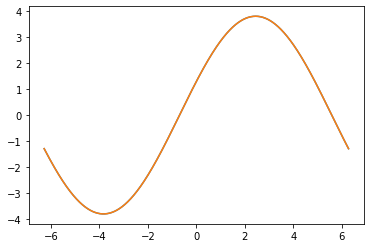

In [3]:
%%time
coeffs0=jnp.array([1, 2, 3, 4], dtype='float32')
n_angles0 = int(jnp.log2(len(coeffs0)))

f0 = trigonometric_landscape(coeffs0, n_angles0)

x_sweep = jnp.linspace(-2*jnp.pi, 2*jnp.pi, 1000)
y = 0.3

plt.plot(x_sweep, vmap(lambda x: f0(jnp.array([x, y], dtype='float32')))(x_sweep))
plt.plot(x_sweep, jnp.cos(x_sweep/2)*jnp.cos(y/2)+
         2*jnp.cos(x_sweep/2)*jnp.sin(y/2)+
         3*jnp.sin(x_sweep/2)*jnp.cos(y/2)+
         4*jnp.sin(x_sweep/2)*jnp.sin(y/2))

In [4]:
def exact_average(F, n_angles):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

def approximate_average(F, n_angles, n_samples, key):
    grid_points = jnp.pi*jnp.array(all_binary_strings(n_angles))
    grid_points = random.permutation(key, grid_points)
    grid_points = grid_points[:n_samples]
    
    F_grid = vmap(F)(grid_points)
    
    return F_grid.sum()/len(grid_points)

Test.

In [5]:
key, subkey = random.split(key)
n_angles = 10
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)


print((coeffs**2).sum()/2**n_angles)
print(exact_average(lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2, n_angles))

0.34455547
0.34455535


In [17]:
%%time
n_angles = 12
key, subkey = random.split(key)
coeffs = random.uniform(subkey, shape=(2**n_angles, ), minval=0, maxval=1)
exact_avg = (coeffs**2).sum()/2**n_angles
F = lambda angles: trigonometric_landscape(coeffs, n_angles)(angles)**2
F=jit(F)

average_list = []
for i in range(n_angles):
    key, subkey = random.split(key)
    average_i = approximate_average(F, n_angles, 2**i, subkey)
    average_list.append(average_i)

CPU times: user 7.57 s, sys: 0 ns, total: 7.57 s
Wall time: 3.54 s


number of angles: 12


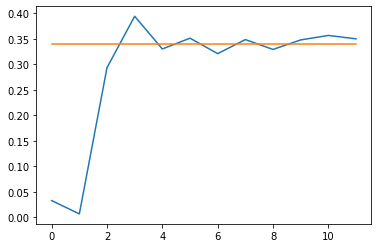

In [18]:
print('number of angles: {}'.format(n_angles))
plt.plot(average_list)
plt.plot([exact_avg]*n_angles)

# Average conjecture test

Now we can test the average conjecture.

In [136]:
n_qubits = 3
a = Ansatz(n_qubits, 'cx', placements={'free':[[1,2], [0,1],[0, 2]]})
# u_func = lambda angs: a.unitary(jnp.array([angs[0], 0, 0, 0, 0, 0], dtype='float32'))
zero_angles = jnp.zeros((a.n_angles, ))
restrinced_angles = lambda angs: zero_angles.at[9].set(angs[0]).at[15].set(angs[1])
u_func = lambda angs: a.unitary(restrinced_angles(angs))
n_angles = 1
a.circuit(restrinced_angles((1, 2))).draw()

┌───────┐┌───────┐┌───────┐                            ┌───────┐┌───────┐»
q_0: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├─────────────────────────■──┤ RY(0) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤     ┌───────┐┌───────┐┌─┴─┐├───────┤├───────┤»
q_1: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├──■──┤ RY(1) ├┤ RX(0) ├┤ X ├┤ RY(2) ├┤ RX(0) ├»
     ├───────┤├───────┤├───────┤┌─┴─┐├───────┤├───────┤└───┘└───────┘└───────┘»
q_2: ┤ RZ(0) ├┤ RX(0) ├┤ RZ(0) ├┤ X ├┤ RY(0) ├┤ RX(0) ├───────────────────────»
     └───────┘└───────┘└───────┘└───┘└───────┘└───────┘                       »
«          ┌───────┐┌───────┐
«q_0: ──■──┤ RY(0) ├┤ RX(0) ├
«       │  └───────┘└───────┘
«q_1: ──┼────────────────────
«     ┌─┴─┐┌───────┐┌───────┐
«q_2: ┤ X ├┤ RY(0) ├┤ RX(0) ├
«     └───┘└───────┘└───────┘

In [141]:
def A_and_B(angles):
    n_angles = len(angles)
    R = 1j*jnp.kron(y_mat, jnp.identity(2**(n_qubits-1)))
    
    W0 = u_func(jnp.zeros((n_angles), dtype='float32'))
    W = u_func(angles)
    
    A = trace_prod(W0, W)
    B = trace_prod(W0, R@W)
    
    return A, B

def A_squared(angles):
    A, _ = A_and_B(angles)
    return A*A.conj()

def B_squared(angles):
    _, B = A_and_B(angles)
    return B*B.conj()

def A_bar_B(angles):
    A, B = A_and_B(angles)
    return A*B.conj()

In [142]:
print(exact_average(A_squared, n_angles))
print(exact_average(B_squared, n_angles))
print(exact_average(A_bar_B, n_angles))

(16+0j)
0j
0j


# Average learning

In [16]:
def optimize_first_angle(f, n_angles, average_func):
    if n_angles == 1:
        return min_angle(lambda ang: f(jnp.array((ang, ))))
    
    def f_to_average(ang, angs):
        angles = jnp.concatenate([jnp.array([ang]), angs])
        return f(angles)
    
    def f1(ang):
        return average_func(lambda angs: f_to_average(ang, angs), n_angles-1)
    
    return min_angle(f1)

def average_learn(u_func, u_target, n_angles, average_func):
    
    def loss0(angles):
        return disc2(u_func(angles), u_target)
    
    optimal_angles = jnp.array([], dtype='float32')
    for n in range(n_angles):
        def loss(angs):
            angles = jnp.concatenate([optimal_angles, angs])
            return loss0(angles)
        n_angs = n_angles - n
        new_angle = optimize_first_angle(loss, n_angs, average_func)
        optimal_angles = jnp.append(optimal_angles, new_angle)

    return optimal_angles

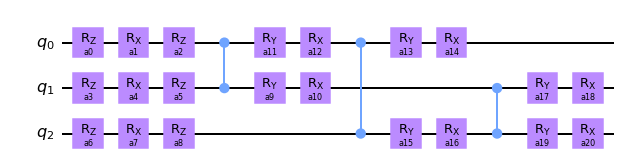

In [114]:
a = Ansatz(3, 'cz', placements={'free':[[1,0], [0, 2], [1, 2]]})
u_target = a.unitary(jnp.array(range(1, a.n_angles+1), dtype='float32'))
a.circuit().draw(output='mpl')

In [115]:
u_restricted = lambda angs: a.unitary(jnp.concatenate([jnp.zeros(shape=(9,)), angs]))
u_target_restricted = u_restricted(jnp.array(range(0, a.n_angles-9),dtype='float32'))

In [116]:
opt_angles = average_learn(u_restricted, u_target_restricted, a.n_angles-9, exact_average)

In [117]:
print(opt_angles)
print(disc2(u_restricted(opt_angles),u_target_restricted))

[ 1.5707964   1.5707964  -0.         -0.         -0.9375348   1.9304514
  0.7853982  -1.5707964   1.5391778  -0.42477575  1.2185782   3.5698256 ]
0.68964493


# Coefficints distribution

### Check `trigonometric_coefficients'.

In [19]:
# Reconstruction from coefficients.
n_angles_rnd = 10
coeffs_rnd = random.uniform(random.PRNGKey(0), shape=(2**n_angles_rnd,), minval=0, maxval=10)
f_rnd = trigonometric_landscape(coeffs_rnd, n_angles_rnd)
get_coeffs_rnd = trigonometric_coefficients(f_rnd, n_angles_rnd)

print(coeffs_rnd)
print(get_coeffs_rnd)

[0.94779134 2.8464484  3.5750294  ... 9.188044   5.129981   5.34206   ]
[0.94779134 2.8464484  3.5750294  ... 9.188043   5.12998    5.3420577 ]


In [20]:
# Reconstruction from funcion.
get_f_rnd = trigonometric_landscape(get_coeffs_rnd, n_angles_rnd)

angles_rnd_sample = random.uniform(random.PRNGKey(0), shape=(n_angles_rnd, ), minval=0, maxval=2*jnp.pi)

print(f_rnd(angles_rnd_sample))
print(get_f_rnd(angles_rnd_sample))

5.2657743
5.265774


In [48]:
a = Ansatz(3, 'cz', placements={'free':[[1,0], [1,2]]})
u_target = a.unitary(jnp.array(range(1, a.n_angles+1), dtype='float32'))
a.circuit().draw(output='mpl')

tr_func = jit(lambda angles: trace_prod(u_target, a.unitary(angles)))
tr_coeffs = trigonometric_coefficients(tr_func, a.n_angles)
tr_func_check = lambda angles: trigonometric_landscape(tr_coeffs, a.n_angles)(angles)

In [49]:
angles = random.uniform(random.PRNGKey(1), shape=(a.n_angles, ), minval=0, maxval=2*jnp.pi)
print(tr_func(angles))
print(tr_func_check(angles))

(-0.5539855-0.1016594j)
(-0.55398566-0.10165937j)


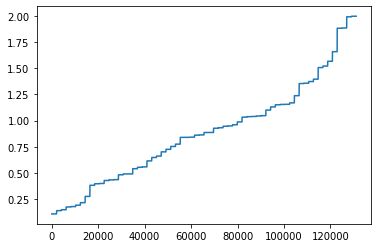

In [50]:
plt.plot(jnp.sort(jnp.abs(tr_coeffs)))

### Check commutator cz and x

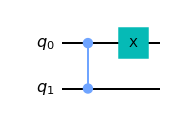

In [13]:
qc = QuantumCircuit(2)
qc.cz(0, 1)
qc.x(0)
u_qc = Operator(qc.reverse_bits()).data

qc.draw(output='mpl')

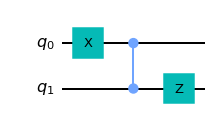

In [14]:
cq = QuantumCircuit(2)
cq.x(0)
cq.cz(0, 1)
cq.z(1)
u_cq = Operator(cq.reverse_bits()).data

cq.draw(output='mpl')

In [15]:
print(jnp.allclose(u_qc, u_cq))

True


### Orthogonality check

In [21]:
%%time
a = Ansatz(3, 'cz', placements={'free':[[0,1], [1, 2]]})
u_coeffs = trigonometric_coefficients(jit(a.unitary), a.n_angles)

CPU times: user 2.02 s, sys: 32.5 ms, total: 2.05 s
Wall time: 2.05 s


In [22]:
%%time
u_0 = u_coeffs[0]
prods = vmap(jit(lambda u: trace_prod(u_0, u)))(u_coeffs)
prods_abs = vmap(jnp.abs)(jnp.array(prods))
prods_abs = prods_abs/prods_abs[0]

CPU times: user 927 ms, sys: 68.4 ms, total: 995 ms
Wall time: 770 ms


In [23]:
zers = jnp.where(jnp.abs(prods_abs)<1e-7)[0]
ons = jnp.where(jnp.abs(prods_abs-1)<1e-7)[0]

print('ones: {}, zeros: {}, sum: {}, total: {}'.format(len(ons), len(zers),len(ons)+len(zers),len(prods_abs)))
print('ratio: {}'.format(len(prods_abs)/len(ons)))
print('guess:: {}'.format(4**a.n_qubits))

ones: 2048, zeros: 129024, sum: 131072, total: 131072
ratio: 64.0
guess:: 64


### Polynomials

In [72]:
def overlaps(u, u_arr):
    return vmap(jit(lambda u_i: trace_prod(u, u_i)))(u_arr)

def choose_basis(u_arr, dim):
    basis = jnp.array([u_arr[0]])
    for u in u_arr:
        if len(basis)==dim:
            return basis
        ovlps = overlaps(u, basis)
        if jnp.all(jnp.abs(ovlps)<1e-6):
            basis = jnp.append(basis, jnp.array([u]), axis=0)
    if len(basis)<dim:
        print('basis not completed')
    return basis

def signature(u, u_arr):
    raw_overlaps = overlaps(u, u_arr)
    signed_overlaps = raw_overlaps / trace_prod(u, u)
    normalized_overlaps = signed_overlaps/jnp.max(jnp.abs(signed_overlaps))
    return jnp.around(normalized_overlaps, decimals=6)

def generate_symbolic_angles(n_angles):
    return [sp.Symbol('x_{}'.format(i)) for i in range(n_angles)]

def monomials(n_angles):
    x_list = generate_symbolic_angles(n_angles)
    mons = []
    for s in all_binary_strings(n_angles):
        factors = [sp.sin(x_list[i]/2) if p else sp.cos(x_list[i]/2) for (i,p) in enumerate(s)]
        product = reduce((lambda x, y: x * y), factors)
        mons.append(product)
    return mons

def trigonometric_polynomial_from_signature(sig, n_angles):
    mons = monomials(n_angles)
    filtered = [s*m for (s, m) in zip(sig, mons)]
    return sum(filtered)

def recostruct_unitary_from_signature(basis, signatures, n_angles):
    
    def f(angles):
        cos_sin = cos_sin_monomials(angles, n_angles)
        total_u = jnp.zeros(basis[0].shape)
        for s, u in zip(signatures, basis):
            total_u += u*((cos_sin*jnp.array(s)).sum())
        return total_u
    
    return f

def reconstruct_unitary_from_trigonometric_polynomial(basis, polynomials, n_angles):
    sym_angles = generate_symbolic_angles(n_angles)
    def f(angles):
        eval_polynomials = [p.subs([(sym_angle, angle) for sym_angle, angle in zip(sym_angles, angles)]) for p in polynomials]
        eval_polynomials = jnp.array(eval_polynomials, dtype='complex64')
        return jnp.tensordot(jnp.array(eval_polynomials), basis, axes=1)
    return f

Single-qubit test.

In [68]:
n_angles = 2
n_qubits = 1
u_func = lambda angs: ry_mat(angs[0]) @ rz_mat(angs[1])
u_coeffs = trigonometric_coefficients(u_func, n_angles)
u_basis = choose_basis(u_coeffs, 4**n_qubits)
u_signatures = vmap(lambda u: signature(u, u_coeffs))(u_basis)
u_polynomials = [trigonometric_polynomial_from_signature(s, n_angles) for s in u_signatures]

u_signature_check = recostruct_unitary_from_signature(u_basis, u_signatures, n_angles)
u_polynomial_check = reconstruct_unitary_from_trigonometric_polynomial(u_basis, u_polynomials, n_angles)

angs = random.uniform(key, shape=(n_angles, ), minval=0, maxval=2*jnp.pi)
print(jnp.allclose(u_func(angs),u_signature_check(angs), atol=1e-7))
print(jnp.allclose(u_func(angs),u_polynomial_check(angs), atol=1e-7))

True
True


In [73]:
n_angles = 3
n_qubits = 2

u_func = lambda angs: jnp.kron(jnp.identity(2), rx_mat(angs[0])) @ cz_mat @ jnp.kron(rz_mat(angs[1]), rx_mat(angs[2]))
u_coeffs = trigonometric_coefficients(u_func, n_angles)
u_basis = choose_basis(u_coeffs, 4**n_qubits)
u_signatures = vmap(lambda u: signature(u, u_coeffs))(u_basis)
u_polynomials = [trigonometric_polynomial_from_signature(s, n_angles) for s in u_signatures]

u_signature_check = recostruct_unitary_from_signature(u_basis, u_signatures, n_angles)
u_polynomial_check = reconstruct_unitary_from_trigonometric_polynomial(u_basis, u_polynomials, n_angles)

angs = random.uniform(key, shape=(n_angles, ), minval=0, maxval=2*jnp.pi)
print(jnp.allclose(u_func(angs),u_signature_check(angs), atol=1e-7))
print(jnp.allclose(u_func(angs),u_polynomial_check(angs), atol=1e-7))

basis not completed
True
True


In [75]:
a = Ansatz(2, 'cz', placements={'free': [[0, 1]]})
n_angles = a.n_angles

u_func = lambda angs: a.unitary(jnp.concatenate([jnp.zeros(a.n_angles-n_angles), angs]))
u_coeffs = trigonometric_coefficients(u_func, n_angles)
u_basis = choose_basis(u_coeffs, 4**a.n_qubits)
u_signatures = vmap(lambda u: signature(u, u_coeffs))(u_basis)
u_polynomials = [trigonometric_polynomial_from_signature(s, n_angles) for s in u_signatures]

u_signature_check = recostruct_unitary_from_signature(u_basis, u_signatures, n_angles)
u_polynomial_check = reconstruct_unitary_from_trigonometric_polynomial(u_basis, u_polynomials, n_angles)

angs = random.uniform(key, shape=(n_angles, ), minval=0, maxval=2*jnp.pi)
print(jnp.allclose(u_func(angs),u_signature_check(angs), atol=1e-7))
print(jnp.allclose(u_func(angs),u_polynomial_check(angs), atol=1e-7))

True
True


# Experiments

True
True
num angles: 5
CPU times: user 1.39 s, sys: 28.7 ms, total: 1.42 s
Wall time: 1.36 s


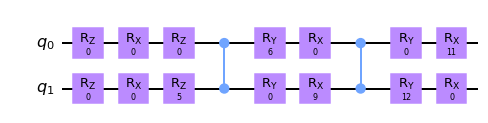

In [129]:
%%time
a = Ansatz(2, 'cz', placements={'free': [[0, 1], [0, 1]]})
positions = [5, 6, 11, 9, 12]
n_angles = len(positions)
def sub_angles(angs, positions, n_all_angles):
    all_angs = jnp.zeros((n_all_angles, ))
    for a, p in zip(angs, positions):
        all_angs = all_angs.at[p].set(a)
    return all_angs

u_func = lambda angs: a.unitary(sub_angles(angs, positions, a.n_angles))
u_coeffs = trigonometric_coefficients(u_func, n_angles)
u_basis = choose_basis(u_coeffs, 4**a.n_qubits)
u_signatures = vmap(lambda u: signature(u, u_coeffs))(u_basis)
u_polynomials = [trigonometric_polynomial_from_signature(s, n_angles) for s in u_signatures]

u_signature_check = recostruct_unitary_from_signature(u_basis, u_signatures, n_angles)
u_polynomial_check = reconstruct_unitary_from_trigonometric_polynomial(u_basis, u_polynomials, n_angles)

angs = random.uniform(key, shape=(n_angles, ), minval=0, maxval=2*jnp.pi)
print(jnp.allclose(u_func(angs),u_signature_check(angs), atol=1e-7))
print(jnp.allclose(u_func(angs),u_polynomial_check(angs), atol=1e-7))

print('num angles: {}'.format(n_angles))
np.array(u_signatures).astype('complex64').tofile('signatures.dat')
np.array(all_binary_strings(n_angles)).astype('int32').tofile('binary_strings.dat')
np.array([n_angles]).astype('int32').tofile('n_angles.dat')

a.circuit(sub_angles(positions, positions, a.n_angles)).draw(output='mpl')